# Introduciton
This is an idea I had before after completing this [tutorial](   https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/) on sentiment analysis on reddit headlines  

[reddit](https://www.reddit.com) is a forum website where people can create subreddits that are communities based on shared interest  

Users post a `submission` to a specific `subreddit` where their visibility is controlled by upvotes and downvotes

Each `submission` has a comment sections where users can `comment` and reply to other users comments

I wanted to be able take the average sentiment score of every `comment` in a `submission` for a variety of reasons.

Sometimes `comment` sections get very negative and it would be interesting to alert the user before they enter the `comment` section. Maybe the positivity of a `comment` section would entice a user to read comments to feel better.

While doing this project I realized that I created an engine that could be used for further analysis to pull entire front pages of a `subreddit` and take the average sentiment of all `submissions` and give that subreddit an average `comment` sentiment score

# Design ideas I had while creating this

In the program I wanted to have this persisting database in the form of a pandas `DataFrame`  

The 2 reasons I used the `DataFrame`
### 1. Easy to perform data analysis on columns  
with functionality like   
`df['label'].mean()`  
it is very easy to find the average sentiment score for a `submission` or `subreddit`  
#### 2. `DataFrame` format can be written into a database easily

# Imports

In [44]:
from IPython import display
import math
from pprint import pprint
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import praw
sns.set(style='darkgrid', context='talk', palette='Dark2')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

# Instanstiate the Reddit API and SentimentIntensityAnalyzer

In [45]:
# Initializes our reddit account api key
reddit = praw.Reddit(client_id='qmZ3LnUz_MoIKQ',
                     client_secret='aMCbdqbHUbQR7DO4w8XRxxVRplY',
                     user_agent='SargentPancakeZ')
# Initializes pretrainded sentiment model
sia = SIA()

# Sentiment Analysis Functions()

In [46]:
def compare_subreddits(subreddits):
    """
    Input:
        list of subreddit names
    
    Output:
        DataFrame with sentiment analysis for all comments from 25 submissions 
        on front page of subreddits passed in by user
    """
    subreddit_sentiments = pd.DataFrame()
    for subreddit in subreddits:
        print(f'[compare_subreddits] starting {subreddit} sentiment analysis')
        print('--------------------------------------------------------------')
        subreddit_sentiment_df = subreddit_sentiment(subreddit)
        subreddit_sentiments = subreddit_sentiments.append(subreddit_sentiment_df, ignore_index=True)
        
    return subreddit_sentiments

In [47]:
def subreddit_sentiment(subreddit):
    """
    Input:
        subreddit

    Functionality:
        Collects comment sentiment from the 25 submissions on the front page of a subreddit
        
    Ouput:
        Comment sentiments for 25 posts on the front page of user supplied subreddit
        
    
    """
    # Create DataFrame that all submission comment sentiments will be appended into
    submission_sentiments = pd.DataFrame()
    for submission in reddit.subreddit(subreddit).hot(limit=25):
        print(f'[{subreddit}_sentiment]: starting submission {submission}')
        submission_sentiment = submission_comment_sentiment(submission)
        submission_sentiments = submission_sentiments.append(submission_sentiment, ignore_index=True)
        
    print('--------------------------------------------------------------')
    return submission_sentiments

In [48]:
def submission_comment_sentiment(submission):
    """
    Input:
        praw.models.submission instance
        https://praw.readthedocs.io/en/latest/code_overview/models/submission.html?highlight=submission
    
    Functionality:
        Takes submission, parses all comments, gives sentiment score for each comment, and places into DataFrame
    
    Output:
        A pandas DataFrame of {comment, compound sentiment score, negitive sentiment, neutral sentiment, posititve sentiment}
    """
    comment_sentiments = pd.DataFrame()
    # Extact all comments from post and find sentiment
    # https://praw.readthedocs.io/en/latest/tutorials/comments.html
    submission.comments.replace_more(limit=None)
    for comment in submission.comments.list():
        comment_sentiment = sia.polarity_scores(comment.body)
        comment_sentiment['comment'] = comment.body
        comment_sentiment['post_id'] = submission.id
        comment_sentiment['subreddit'] = submission.subreddit
        comment_sentiments = comment_sentiments.append(comment_sentiment, ignore_index=True)
        
    comment_sentiments = label_df(comment_sentiments)
    return comment_sentiments

In [49]:
def label_df(df):
    """
    Input:
        Sentiment score DataFrame from submission_comment_sentiment()
    
    Functionality:
        labels DataFrame based on compound sentiment score
        
        1 = positive
        0 = neutral
        -1 = negative
    
    Output:
        labeled Dataframe
    """
    #set label to 0 for all posts
    df['label'] = 0
    #set label to 1 where compound is > .2
    df.loc[df['compound'] > 0.2, 'label'] = 1
    #set label to -1 where compound is < .2
    df.loc[df['compound'] < -0.2, 'label'] = -1
    return df

# Run the code  
politics is a place for political discourse which I thought might have a more negative disposition   
aww is a happy place for animal photos

In [50]:
subreddits = ['politics','aww']
df = compare_subreddits(subreddits)

[compare_subreddits] starting politics sentiment analysis
--------------------------------------------------------------
[politics_sentiment]: starting submission b8kf27
[politics_sentiment]: starting submission b8np4y
[politics_sentiment]: starting submission b8loqn
[politics_sentiment]: starting submission b8mouf
[politics_sentiment]: starting submission b8nskk
[politics_sentiment]: starting submission b8lyu3
[politics_sentiment]: starting submission b8l8ov
[politics_sentiment]: starting submission b8lmlu
[politics_sentiment]: starting submission b8mvsh
[politics_sentiment]: starting submission b8k6rt
[politics_sentiment]: starting submission b8jeum
[politics_sentiment]: starting submission b8j1dz
[politics_sentiment]: starting submission b8mbvm
[politics_sentiment]: starting submission b8kjgh
[politics_sentiment]: starting submission b8kuj5
[politics_sentiment]: starting submission b8jtcu
[politics_sentiment]: starting submission b8n7ze
[politics_sentiment]: starting submission b8ig

# Politics Analysis Results
The average label and compound scores show that the average comment sentiment tends to be neutral with a slight advantage towards positive

In [51]:
df[df['subreddit'] == 'politics']['label'].mean()

0.03785966683493185

In [52]:
df[df['subreddit'] == 'politics']['compound'].mean()

0.016124520444219966

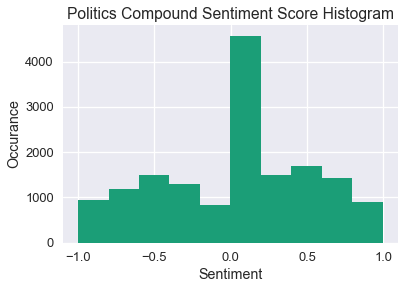

In [62]:
politics_df = df[df['subreddit'] == 'politics']
plt.hist(politics_df['compound'])
plt.xlabel('Sentiment')
plt.ylabel('Occurance')
plt.title('Politics Compound Sentiment Score Histogram')
plt.show()

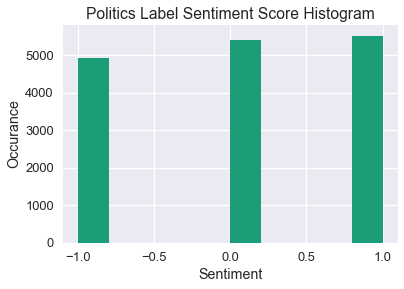

In [63]:
politics_df = df[df['subreddit'] == 'politics']
plt.hist(politics_df['label'])
plt.xlabel('Sentiment')
plt.ylabel('Occurance')
plt.title('Politics Label Sentiment Score Histogram')
plt.show()

# Aww Analysis Results
The average label and compound scores show that the average comment sentiment tends to be positive

In [54]:
df[df['subreddit'] == 'aww']['label'].mean()

0.3431034482758621

In [55]:
df[df['subreddit'] == 'aww']['compound'].mean()

0.22411637931034437

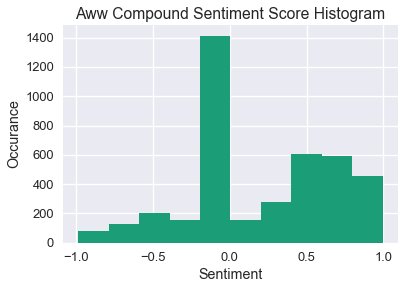

In [66]:
aww_df = df[df['subreddit'] == 'aww']
plt.hist(aww_df['compound'])
plt.xlabel('Sentiment')
plt.ylabel('Occurance')
plt.title('Aww Compound Sentiment Score Histogram')
plt.show()

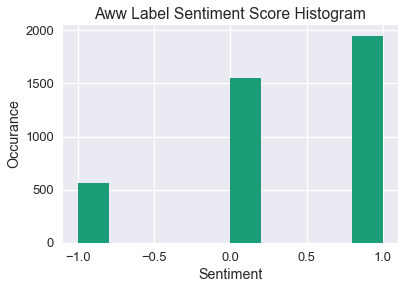

In [65]:
plt.hist(aww_df['label'])
plt.xlabel('Sentiment')
plt.ylabel('Occurance')
plt.title('Aww Label Sentiment Score Histogram')
plt.show()

# How can this be used?
### 1. Display sentiment score for each post as a browser addon  
This allows users to see sentiment before they go into the comment section and gives them a better   idea of the mood and discourse  
### 2. Display sentiment score for each subreddit at the top as a browser addon
### 3. Perform large scale analysis on sentiment across subreddits 
 
Overall all the functions have been made modularly and can be applied to the ideas I have set forward, but can also be used in the creation of new analysis later